In [1]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from causalgraphicalmodels import CausalGraphicalModel
from dowhy import CausalModel
import dowhy.datasets
from networkx.drawing.nx_pydot import write_dot
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite.gml import write_gml
import numpy as np

In [2]:
def gen_estimate(gml_graph, input_df, treatment_col, outcome_col):
        # With graph
    model=CausalModel(
            data = input_df,
            treatment=treatment_col,
            outcome=outcome_col,
            graph=gml_graph
            )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.linear_regression",target_units="ate")
    print(causal_estimate)
    return causal_estimate.value

In [3]:
def filter_skewed(treatment_cols, seasons, df):
    values = []
    for t in treatment_cols:
        print(t)
        tmp = []
        for s in seasons:
            print(s)
            one_season = df[df['season'] == s]
            treated = len(one_season[one_season[t] == 1])
            untreated = len(one_season[one_season[t] == 0])
            th_treated = treated/(treated + untreated)
            th_untreated = untreated/(treated + untreated)
            if (th_treated >= 0.3) and (th_untreated >= 0.3):
                tmp.append(1)
            else:
                tmp.append(None)
        print(tmp)
        values.append(tmp)
    return dict(zip(treatment_cols, values))

In [4]:
def get_df(treatment, df):
    df_return = df
    min_ = round(df_return[treatment].min(), 3)
    max_ = round(df_return[treatment].max(), 3)
    interval = [min_, max_]
    p_25 = round(np.percentile(interval, 25), 3)
    p_50 = round(np.percentile(interval, 50), 3)
    p_75 = round(np.percentile(interval, 75), 3)
    column = [min_, p_25, p_50, p_75, max_]
    column_name = [treatment+str(min_)+'_'+str(p_25), treatment+str(p_25)+'_'+str(p_50), 
                   treatment+str(p_50)+'_'+str(p_75), treatment+str(p_75)+'_'+str(max_)]
    
    for i in range(len(column_name)):
        df_return[column_name[i]] = 0
        slice_indices = (df_return[treatment] > column[i] - 0.001) & (df[treatment] <= column[i+1])
        df_return.loc[slice_indices, column_name[i]]=1
    
    return df_return, column_name

In [5]:
def graph(treatment, treatmemt_i, outcome):
    lst = [
            ("Minutes", "Assists"), 
            ("Minutes", "Rebounds"), 
            ("Minutes", "Points"), 
            ("Fg3Pct", "Points"),
            ("Fg2Pct", "Points"), 
            ("Points", outcome),
            ("Assists", outcome),
            ("Rebounds", outcome),
            ("Turnovers", outcome),
            ("Fouls", outcome),
            ("is_home", outcome),
    ]
    
    for i in range(len(lst)):
        lst[i] = list(lst[i])
        if lst[i][0] == treatment:
            lst[i][0] = treatmemt_i
        if lst[i][1] == treatment:
            lst[i][1] = treatmemt_i
        lst[i] = tuple(lst[i])

    G = nx.DiGraph()
    G.add_edges_from(lst)
    write_gml(G, 'testgml')
    with open('testgml') as f: s = f.read()
    return s

In [6]:
def get_est(player_name, treatment, outcome, season_type):
    loc = '/Users/sdy/Desktop/Casual Inference/' + str(player_name) + '.csv'
    df = pd.read_csv(loc)
    df = df.fillna(0)
    df = df.drop(['Unnamed: 0'],axis=1)
    df = df.drop(["Date","HomePoints",
                         "AwayPoints", "HomeTeamAbbreviation","AwayTeamAbbreviation", 
                         "FtPoints", "FG2A", "FG3A"],axis=1)
    
    seasons = df['season'].unique()
    
    if season_type == 'Regular Season':
        df_regular = df[df['season_type'] == 'Regular Season']
        df, treatment_cols = get_df(treatment, df_regular)
        th = filter_skewed(treatment_cols, seasons, df)
        df = df.groupby('season')
    
    if season_type == 'Playoffs':
        df_playoff = df[df['season_type'] == 'Playoffs']
        df, treatment_cols = get_df(treatment, df_playoff)
        th = filter_skewed(treatment_cols, seasons, df)
        df = df.groupby('season')


    estimates  = []
    
    for t in treatment_cols:
        th_i = th.get(t)
        i = 0
        for season, split_df in df:
            if th_i[i] == None:
                estimates.append({'treatment':t, 'outcome':outcome, 'season':season,'ate':None})
            else:
                try:
                    est = gen_estimate(graph(treatment, t, outcome),split_df,t,outcome)
                    estimates.append({'treatment':t, 'outcome':outcome, 'season':season,'ate':est})
                except:
                    estimates.append({'treatment':t, 'season':season, 'estimate':None})
            i = i+1
    estimates_df=pd.DataFrame(estimates)
    
    return estimates_df 

# Causal Graph

In [7]:
loc = '/Users/sdy/Desktop/Casual Inference/herro.csv'
df = pd.read_csv(loc)
df = df.fillna(0)
df = df.drop(['Unnamed: 0'],axis=1)
df = df.drop(["Date","HomePoints",
                     "AwayPoints", "HomeTeamAbbreviation","AwayTeamAbbreviation", 
                     "FtPoints", "FG2A", "FG3A"],axis=1)

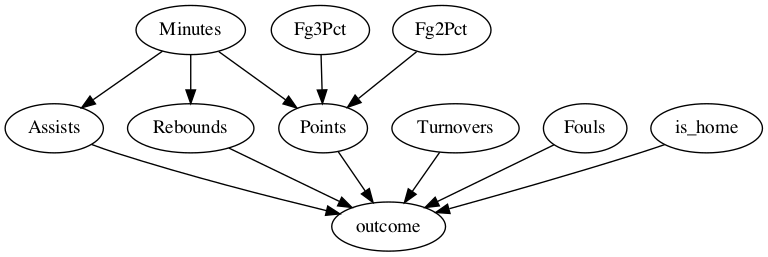

In [9]:
outcome = 'outcome'
lst = [
        ("Minutes", "Assists"), 
        ("Minutes", "Rebounds"), 
        ("Minutes", "Points"), 
        ("Fg3Pct", "Points"),
        ("Fg2Pct", "Points"), 
        ("Points", outcome),
        ("Assists", outcome),
        ("Rebounds", outcome),
        ("Turnovers", outcome),
        ("Fouls", outcome),
        ("is_home", outcome),
]

G = nx.DiGraph()
G.add_edges_from(lst)
write_gml(G, 'testgml')
with open('testgml') as f: s = f.read()
    
import pygraphviz

model= dowhy.CausalModel(
        data = df,
        graph=s,
        treatment= 'Minutes',
        outcome= 'mia_points')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Herro

## outcome = mia_points

In [10]:
estimate_df_minutes_mia_points = get_est('herro', 'Minutes', 'mia_points', 'Regular Season')

estimate_df_assists_mia_points = get_est('herro', 'Assists', 'mia_points', 'Regular Season')

estimate_df_rebounds_mia_points = get_est('herro', 'Rebounds', 'mia_points', 'Regular Season')

estimate_df_points_mia_points = get_est('herro', 'Points', 'mia_points', 'Regular Season')

estimate_df_turnovers_mia_points = get_est('herro', 'Turnovers', 'mia_points', 'Regular Season')

estimate_df_fouls_mia_points = get_est('herro', 'Fouls', 'mia_points', 'Regular Season')

estimate_df_fg3_mia_points = get_est('herro', 'Fg3Pct', 'mia_points', 'Regular Season')

estimate_df_fg2_mia_points = get_est('herro', 'Fg2Pct', 'mia_points', 'Regular Season')

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Minutes7.3_16.658
2019-20
2020-21
2021-22
[None, None, None]
Minutes16.658_26.016
2019-20
2020-21
2021-22
[1, None, None]
Minutes26.016_35.375
2019-20
2020-21
2021-22
[1, 1, None]
Minutes35.375_44.733
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                         
───────────────────────(E[miaₚₒᵢₙₜₛ])
d[Minutes16.658_26.016]              
Estimand assumption 1, Unconfoundedness: If U→{Minutes16.658_26.016} and U→mia_points then P(mia_points|Minutes16.658_26.016,,U) = P(mia_points|Minutes16.658_26.016,)

## Realized estimand
b: mia_points~Minutes16.658_26.016+Minutes16.658_26.016*Fg2Pct+Minutes16.658_26.016*is_home+Minutes16.658_26.016*Fg3Pct+Minutes16.658_26.016*Fouls+Minutes16.658_26.016*Turnovers
Target units: ate

## Estimate
Mean value: -0.8928445452224736

*** Causal Estimate ***

## Identified estimand
Estima

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                
───────────────────(E[mia_points|Minutes])
d[Rebounds3.75_7.5]                       
Estimand assumption 1, Unconfoundedness: If U→{Rebounds3.75_7.5} and U→mia_points then P(mia_points|Rebounds3.75_7.5,Minutes,U) = P(mia_points|Rebounds3.75_7.5,Minutes)

## Realized estimand
b: mia_points~Rebounds3.75_7.5+Minutes+Rebounds3.75_7.5*Fg2Pct+Rebounds3.75_7.5*is_home+Rebounds3.75_7.5*Assists+Rebounds3.75_7.5*Points+Rebounds3.75_7.5*Fg3Pct+Rebounds3.75_7.5*Fouls+Rebounds3.75_7.5*Turnovers
Target units: ate

## Estimate
Mean value: 4.451819134395336

Points0.0_8.75
2019-20
2020-21
2021-22
[None, None, None]
Points8.75_17.5
2019-20
2020-21
2021-22
[1, 1, 1]
Points17.5_26.25
2019-20
2020-21
2021-22
[None, None, 1]
Points26.25_35.0
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***



/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
────────────────(E[miaₚₒᵢₙₜₛ])
d[Fouls0.0_1.25]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls0.0_1.25} and U→mia_points then P(mia_points|Fouls0.0_1.25,,U) = P(mia_points|Fouls0.0_1.25,)

## Realized estimand
b: mia_points~Fouls0.0_1.25+Fouls0.0_1.25*is_home+Fouls0.0_1.25*Assists+Fouls0.0_1.25*Minutes+Fouls0.0_1.25*Turnovers+Fouls0.0_1.25*Fg2Pct+Fouls0.0_1.25*Points+Fouls0.0_1.25*Fg3Pct+Fouls0.0_1.25*Rebounds
Target units: ate

## Estimate
Mean value: -2.821334401955184

Fg3Pct0.0_0.214
2019-20
2020-21
2021-22
[None, 1, None]
Fg3Pct0.214_0.428
2019-20
2020-21
2021-22
[1, None, 1]
Fg3Pct0.428_0.643
2019-20
2020-21
2021-22
[None, None, 1]
Fg3Pct0.643_0.857
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAME

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [11]:
estimate_mia_points = pd.concat([estimate_df_minutes_mia_points, estimate_df_assists_mia_points, estimate_df_rebounds_mia_points, 
                 estimate_df_points_mia_points, estimate_df_turnovers_mia_points, estimate_df_fouls_mia_points, 
                 estimate_df_fg3_mia_points, estimate_df_fg2_mia_points], ignore_index=True)


In [12]:
estimate_mia_points.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
80,Fg3Pct0.428_0.643,mia_points,2021-22,6.327129
17,Assists2.75_5.5,mia_points,2021-22,5.825654
29,Rebounds3.75_7.5,mia_points,2021-22,4.451819
92,Fg2Pct0.5_0.75,mia_points,2021-22,3.892101
6,Minutes26.016_35.375,mia_points,2019-20,3.006094
52,Turnovers2.0_4.0,mia_points,2020-21,2.644993
12,Assists0.0_2.75,mia_points,2019-20,2.414252
91,Fg2Pct0.5_0.75,mia_points,2020-21,2.282158
39,Points8.75_17.5,mia_points,2019-20,2.036286
16,Assists2.75_5.5,mia_points,2020-21,2.021127


## outcome is win/lose

In [13]:
estimate_df_minutes_outcome = get_est('herro', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('herro', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('herro', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('herro', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('herro', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('herro', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('herro', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('herro', 'Fg2Pct', 'outcome', 'Regular Season')

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Minutes7.3_16.658
2019-20
2020-21
2021-22
[None, None, None]
Minutes16.658_26.016
2019-20
2020-21
2021-22
[1, None, None]
Minutes26.016_35.375
2019-20
2020-21
2021-22
[1, 1, None]
Minutes35.375_44.733
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                       
───────────────────────(E[outcome])
d[Minutes16.658_26.016]            
Estimand assumption 1, Unconfoundedness: If U→{Minutes16.658_26.016} and U→outcome then P(outcome|Minutes16.658_26.016,,U) = P(outcome|Minutes16.658_26.016,)

## Realized estimand
b: outcome~Minutes16.658_26.016+Minutes16.658_26.016*Fg2Pct+Minutes16.658_26.016*is_home+Minutes16.658_26.016*Fg3Pct+Minutes16.658_26.016*Fouls+Minutes16.658_26.016*Turnovers
Target units: ate

## Estimate
Mean value: 0.09093317925202093

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandT

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Points0.0_8.75
2019-20
2020-21
2021-22
[None, None, None]
Points8.75_17.5
2019-20
2020-21
2021-22
[1, 1, 1]
Points17.5_26.25
2019-20
2020-21
2021-22
[None, None, 1]
Points26.25_35.0
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
──────────────────(E[outcome|Minutes])
d[Points8.75_17.5]                    
Estimand assumption 1, Unconfoundedness: If U→{Points8.75_17.5} and U→outcome then P(outcome|Points8.75_17.5,Minutes,U) = P(outcome|Points8.75_17.5,Minutes)

## Realized estimand
b: outcome~Points8.75_17.5+Minutes+Points8.75_17.5*is_home+Points8.75_17.5*Assists+Points8.75_17.5*Rebounds+Points8.75_17.5*Fouls+Points8.75_17.5*Turnovers
Target units: ate

## Estimate
Mean value: 0.306238481542295

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estim

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                      
────────────────────(E[outcome])
d[Fg3Pct0.214_0.428]            
Estimand assumption 1, Unconfoundedness: If U→{Fg3Pct0.214_0.428} and U→outcome then P(outcome|Fg3Pct0.214_0.428,,U) = P(outcome|Fg3Pct0.214_0.428,)

## Realized estimand
b: outcome~Fg3Pct0.214_0.428+Fg3Pct0.214_0.428*is_home+Fg3Pct0.214_0.428*Assists+Fg3Pct0.214_0.428*Minutes+Fg3Pct0.214_0.428*Fouls+Fg3Pct0.214_0.428*Turnovers+Fg3Pct0.214_0.428*Fg2Pct+Fg3Pct0.214_0.428*Rebounds
Target units: ate

## Estimate
Mean value: -0.06475188446694202

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                      
────────────────────(E[outcome])
d[Fg3Pct0.214_0.428]            
Estimand assumption 1, Unconfoundedness: 

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [14]:
estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


In [15]:
estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
39,Points8.75_17.5,outcome,2019-20,0.306238
92,Fg2Pct0.5_0.75,outcome,2021-22,0.202102
6,Minutes26.016_35.375,outcome,2019-20,0.194468
16,Assists2.75_5.5,outcome,2020-21,0.168583
44,Points17.5_26.25,outcome,2021-22,0.167774
51,Turnovers2.0_4.0,outcome,2019-20,0.154957
53,Turnovers2.0_4.0,outcome,2021-22,0.132686
88,Fg2Pct0.25_0.5,outcome,2020-21,0.105781
29,Rebounds3.75_7.5,outcome,2021-22,0.097285
3,Minutes16.658_26.016,outcome,2019-20,0.090933


# Jimmy Butler

## outcome_mia_points

In [16]:
estimate_df_minutes_mia_points = get_est('jimmy', 'Minutes', 'mia_points', 'Regular Season')

estimate_df_assists_mia_points = get_est('jimmy', 'Assists', 'mia_points', 'Regular Season')

estimate_df_rebounds_mia_points = get_est('jimmy', 'Rebounds', 'mia_points', 'Regular Season')

estimate_df_points_mia_points = get_est('jimmy', 'Points', 'mia_points', 'Regular Season')

estimate_df_turnovers_mia_points = get_est('jimmy', 'Turnovers', 'mia_points', 'Regular Season')

estimate_df_fouls_mia_points = get_est('jimmy', 'Fouls', 'mia_points', 'Regular Season')

estimate_df_fg3_mia_points = get_est('jimmy', 'Fg3Pct', 'mia_points', 'Regular Season')

estimate_df_fg2_mia_points = get_est('jimmy', 'Fg2Pct', 'mia_points', 'Regular Season')

estimate_mia_points = pd.concat([estimate_df_minutes_mia_points, estimate_df_assists_mia_points, estimate_df_rebounds_mia_points, 
                 estimate_df_points_mia_points, estimate_df_turnovers_mia_points, estimate_df_fouls_mia_points, 
                 estimate_df_fg3_mia_points, estimate_df_fg2_mia_points], ignore_index=True)

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Minutes12.0_22.117
2019-20
2020-21
2021-22
[None, None, None]
Minutes22.117_32.234
2019-20
2020-21
2021-22
[None, None, None]
Minutes32.234_42.35
2019-20
2020-21
2021-22
[1, None, None]
Minutes42.35_52.467
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                         
──────────────────────(E[miaₚₒᵢₙₜₛ])
d[Minutes32.234_42.35]              
Estimand assumption 1, Unconfoundedness: If U→{Minutes32.234_42.35} and U→mia_points then P(mia_points|Minutes32.234_42.35,,U) = P(mia_points|Minutes32.234_42.35,)

## Realized estimand
b: mia_points~Minutes32.234_42.35+Minutes32.234_42.35*Fg2Pct+Minutes32.234_42.35*is_home+Minutes32.234_42.35*Fg3Pct+Minutes32.234_42.35*Fouls+Minutes32.234_42.35*Turnovers
Target units: ate

## Estimate
Mean value: -4.133832776816263

Assists0.0_3.75
2019-20
2020-21
2021-22
[None, None, None]
Ass

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                
──────────────────(E[mia_points|Minutes])
d[Points11.0_20.0]                       
Estimand assumption 1, Unconfoundedness: If U→{Points11.0_20.0} and U→mia_points then P(mia_points|Points11.0_20.0,Minutes,U) = P(mia_points|Points11.0_20.0,Minutes)

## Realized estimand
b: mia_points~Points11.0_20.0+Minutes+Points11.0_20.0*is_home+Points11.0_20.0*Assists+Points11.0_20.0*Rebounds+Points11.0_20.0*Fouls+Points11.0_20.0*Turnovers
Target units: ate

## Estimate
Mean value: -6.7913874939597605

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                
──────────────────(E[mia_points|Minutes])
d[Points20.0_29.0]                       
Estimand assumption 1, 

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[miaₚₒᵢₙₜₛ])
d[Fouls0.0_1.0]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls0.0_1.0} and U→mia_points then P(mia_points|Fouls0.0_1.0,,U) = P(mia_points|Fouls0.0_1.0,)

## Realized estimand
b: mia_points~Fouls0.0_1.0+Fouls0.0_1.0*is_home+Fouls0.0_1.0*Assists+Fouls0.0_1.0*Minutes+Fouls0.0_1.0*Turnovers+Fouls0.0_1.0*Fg2Pct+Fouls0.0_1.0*Points+Fouls0.0_1.0*Fg3Pct+Fouls0.0_1.0*Rebounds
Target units: ate

## Estimate
Mean value: -1.0582391687727863

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[miaₚₒᵢₙₜₛ])
d[Fouls1.0_2.0]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls1.0_2.0} and U→mia_points then

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [17]:
estimate_mia_points.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
26,Rebounds0.0_4.5,mia_points,2021-22,8.976606
91,Fg2Pct0.5_0.75,mia_points,2020-21,8.532420
92,Fg2Pct0.5_0.75,mia_points,2021-22,8.238774
44,Points20.0_29.0,mia_points,2021-22,7.378703
68,Fouls2.0_3.0,mia_points,2021-22,5.218432
51,Turnovers1.5_3.0,mia_points,2019-20,4.253563
56,Turnovers3.0_4.5,mia_points,2021-22,3.362957
19,Assists7.5_11.25,mia_points,2020-21,3.185348
42,Points20.0_29.0,mia_points,2019-20,3.136195
65,Fouls1.0_2.0,mia_points,2021-22,2.684787


## outcome_win_lose

In [18]:
estimate_df_minutes_outcome = get_est('jimmy', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('jimmy', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('jimmy', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('jimmy', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('jimmy', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('jimmy', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('jimmy', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('jimmy', 'Fg2Pct', 'outcome', 'Regular Season')

estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Minutes12.0_22.117
2019-20
2020-21
2021-22
[None, None, None]
Minutes22.117_32.234
2019-20
2020-21
2021-22
[None, None, None]
Minutes32.234_42.35
2019-20
2020-21
2021-22
[1, None, None]
Minutes42.35_52.467
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                       
──────────────────────(E[outcome])
d[Minutes32.234_42.35]            
Estimand assumption 1, Unconfoundedness: If U→{Minutes32.234_42.35} and U→outcome then P(outcome|Minutes32.234_42.35,,U) = P(outcome|Minutes32.234_42.35,)

## Realized estimand
b: outcome~Minutes32.234_42.35+Minutes32.234_42.35*Fg2Pct+Minutes32.234_42.35*is_home+Minutes32.234_42.35*Fg3Pct+Minutes32.234_42.35*Fouls+Minutes32.234_42.35*Turnovers
Target units: ate

## Estimate
Mean value: -0.09472264511768491

Assists0.0_3.75
2019-20
2020-21
2021-22
[None, None, None]
Assists3.75_7.5
201

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
──────────────────(E[outcome|Minutes])
d[Points11.0_20.0]                    
Estimand assumption 1, Unconfoundedness: If U→{Points11.0_20.0} and U→outcome then P(outcome|Points11.0_20.0,Minutes,U) = P(outcome|Points11.0_20.0,Minutes)

## Realized estimand
b: outcome~Points11.0_20.0+Minutes+Points11.0_20.0*is_home+Points11.0_20.0*Assists+Points11.0_20.0*Rebounds+Points11.0_20.0*Fouls+Points11.0_20.0*Turnovers
Target units: ate

## Estimate
Mean value: -0.015897084316961685

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
──────────────────(E[outcome|Minutes])
d[Points20.0_29.0]                    
Estimand assumption 1, Unconfoundedness: If U→{Poin

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[Fouls0.0_1.0]            
Estimand assumption 1, Unconfoundedness: If U→{Fouls0.0_1.0} and U→outcome then P(outcome|Fouls0.0_1.0,,U) = P(outcome|Fouls0.0_1.0,)

## Realized estimand
b: outcome~Fouls0.0_1.0+Fouls0.0_1.0*is_home+Fouls0.0_1.0*Assists+Fouls0.0_1.0*Minutes+Fouls0.0_1.0*Turnovers+Fouls0.0_1.0*Fg2Pct+Fouls0.0_1.0*Points+Fouls0.0_1.0*Fg3Pct+Fouls0.0_1.0*Rebounds
Target units: ate

## Estimate
Mean value: -0.34758450098673577

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[Fouls0.0_1.0]            
Estimand assumption 1, Unconfoundedness: If U→{Fouls0.0_1.0} and U→outcome then P(outcome|Fouls0.0_1.0,,U

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_73526/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [19]:
estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
43,Points20.0_29.0,outcome,2020-21,0.452230
26,Rebounds0.0_4.5,outcome,2021-22,0.317641
56,Turnovers3.0_4.5,outcome,2021-22,0.306422
68,Fouls2.0_3.0,outcome,2021-22,0.303925
52,Turnovers1.5_3.0,outcome,2020-21,0.278556
19,Assists7.5_11.25,outcome,2020-21,0.261956
66,Fouls2.0_3.0,outcome,2019-20,0.202398
28,Rebounds4.5_9.0,outcome,2020-21,0.187351
44,Points20.0_29.0,outcome,2021-22,0.144494
88,Fg2Pct0.25_0.5,outcome,2020-21,0.135740


# Curry

## outcome_gsw_points

In [20]:
estimate_df_minutes_gsw_points = get_est('curry', 'Minutes', 'gsw_points', 'Regular Season')

estimate_df_assists_gsw_points = get_est('curry', 'Assists', 'gsw_points', 'Regular Season')

estimate_df_rebounds_gsw_points = get_est('curry', 'Rebounds', 'gsw_points', 'Regular Season')

estimate_df_points_gsw_points = get_est('curry', 'Points', 'gsw_points', 'Regular Season')

estimate_df_turnovers_gsw_points = get_est('curry', 'Turnovers', 'gsw_points', 'Regular Season')

estimate_df_fouls_gsw_points = get_est('curry', 'Fouls', 'gsw_points', 'Regular Season')

estimate_df_fg3_gsw_points = get_est('curry', 'Fg3Pct', 'gsw_points', 'Regular Season')

estimate_df_fg2_gsw_points = get_est('curry', 'Fg2Pct', 'gsw_points', 'Regular Season')

estimate_gsw_points = pd.concat([estimate_df_minutes_gsw_points, estimate_df_assists_gsw_points, estimate_df_rebounds_gsw_points, 
                 estimate_df_points_gsw_points, estimate_df_turnovers_gsw_points, estimate_df_fouls_gsw_points, 
                 estimate_df_fg3_gsw_points, estimate_df_fg2_gsw_points], ignore_index=True)


Minutes14.383_22.837
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
Minutes22.837_31.292
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, None, None, None]
Minutes31.292_39.746
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, 1]
Minutes39.746_48.2
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, 1, 1, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                         
───────────────────────(E[gswₚₒᵢₙₜₛ])
d[Minutes22.837_31.292]              
Estimand assumption 1, Unconfoundedness: If U→{Minutes22.837_31.292} and U→gsw_points then P(gsw_points|Minutes22.837_31.292,,U) = P(gsw_points|Minutes22.837_31.292,)

## Realized estimand
b: gsw_points~Minutes22.837_31.292+Minutes22.837_31.292*Fg2Pct+Minutes22.837_31.292*is_home+Minutes22.837_31.292*Fg3Pct+Minutes22.837_31.292*Fouls+Minutes22.837_31.292*Turnovers
Target units: ate

## E

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
─────────────────(E[gsw_points|Minutes])
d[Assists4.0_8.0]                       
Estimand assumption 1, Unconfoundedness: If U→{Assists4.0_8.0} and U→gsw_points then P(gsw_points|Assists4.0_8.0,Minutes,U) = P(gsw_points|Assists4.0_8.0,Minutes)

## Realized estimand
b: gsw_points~Assists4.0_8.0+Minutes+Assists4.0_8.0*Fg2Pct+Assists4.0_8.0*Rebounds+Assists4.0_8.0*is_home+Assists4.0_8.0*Points+Assists4.0_8.0*Fg3Pct+Assists4.0_8.0*Fouls+Assists4.0_8.0*Turnovers
Target units: ate

## Estimate
Mean value: -6.6163706704598155

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
─────────────────(E[gsw_points|Minutes])
d[Assists4.0_8.0]                   

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                
──────────────────(E[gsw_points|Minutes])
d[Rebounds3.5_7.0]                       
Estimand assumption 1, Unconfoundedness: If U→{Rebounds3.5_7.0} and U→gsw_points then P(gsw_points|Rebounds3.5_7.0,Minutes,U) = P(gsw_points|Rebounds3.5_7.0,Minutes)

## Realized estimand
b: gsw_points~Rebounds3.5_7.0+Minutes+Rebounds3.5_7.0*Fg2Pct+Rebounds3.5_7.0*is_home+Rebounds3.5_7.0*Assists+Rebounds3.5_7.0*Points+Rebounds3.5_7.0*Fg3Pct+Rebounds3.5_7.0*Fouls+Rebounds3.5_7.0*Turnovers
Target units: ate

## Estimate
Mean value: -3.8237327221217328

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                
──────────────────(E[gsw_points|Minutes])
d[Rebounds3.5_7.0]   

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                        
────────────────────(E[gswₚₒᵢₙₜₛ])
d[Turnovers2.75_5.5]              
Estimand assumption 1, Unconfoundedness: If U→{Turnovers2.75_5.5} and U→gsw_points then P(gsw_points|Turnovers2.75_5.5,,U) = P(gsw_points|Turnovers2.75_5.5,)

## Realized estimand
b: gsw_points~Turnovers2.75_5.5+Turnovers2.75_5.5*is_home+Turnovers2.75_5.5*Assists+Turnovers2.75_5.5*Minutes+Turnovers2.75_5.5*Fouls+Turnovers2.75_5.5*Fg2Pct+Turnovers2.75_5.5*Points+Turnovers2.75_5.5*Fg3Pct+Turnovers2.75_5.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.4770082848977637

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                        
────────────────────(E[gswₚₒᵢₙₜₛ])
d[Turnovers2.75_5.5]           

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[gswₚₒᵢₙₜₛ])
d[Fouls3.0_4.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls3.0_4.5} and U→gsw_points then P(gsw_points|Fouls3.0_4.5,,U) = P(gsw_points|Fouls3.0_4.5,)

## Realized estimand
b: gsw_points~Fouls3.0_4.5+Fouls3.0_4.5*is_home+Fouls3.0_4.5*Assists+Fouls3.0_4.5*Minutes+Fouls3.0_4.5*Turnovers+Fouls3.0_4.5*Fg2Pct+Fouls3.0_4.5*Points+Fouls3.0_4.5*Fg3Pct+Fouls3.0_4.5*Rebounds
Target units: ate

## Estimate
Mean value: 0.10519291883456106

Fg3Pct0.0_0.25
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
Fg3Pct0.25_0.5
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, 1]
Fg3Pct0.5_0.75
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, 1]
Fg3Pct0.75_1.0
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
*** Causal Esti

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                      
─────────────────(E[gswₚₒᵢₙₜₛ])
d[Fg2Pct0.25_0.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U→gsw_points then P(gsw_points|Fg2Pct0.25_0.5,,U) = P(gsw_points|Fg2Pct0.25_0.5,)

## Realized estimand
b: gsw_points~Fg2Pct0.25_0.5+Fg2Pct0.25_0.5*is_home+Fg2Pct0.25_0.5*Assists+Fg2Pct0.25_0.5*Minutes+Fg2Pct0.25_0.5*Fouls+Fg2Pct0.25_0.5*Turnovers+Fg2Pct0.25_0.5*Fg3Pct+Fg2Pct0.25_0.5*Rebounds
Target units: ate

## Estimate
Mean value: 0.020503072484203244

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                      
─────────────────(E[gswₚₒᵢₙₜₛ])
d[Fg2Pct0.25_0.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U

In [21]:
estimate_gsw_points.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
74,Points29.5_41.75,gsw_points,2016-17,10.959795
154,Fg2Pct0.5_0.75,gsw_points,2016-17,9.096954
133,Fg3Pct0.5_0.75,gsw_points,2015-16,7.496588
33,Assists8.0_12.0,gsw_points,2015-16,6.940301
6,Minutes22.837_31.292,gsw_points,2013-14,6.590733
134,Fg3Pct0.5_0.75,gsw_points,2016-17,6.081663
150,Fg2Pct0.5_0.75,gsw_points,2012-13,5.721883
111,Fouls3.0_4.5,gsw_points,2013-14,4.704752
132,Fg3Pct0.5_0.75,gsw_points,2014-15,4.614187
151,Fg2Pct0.5_0.75,gsw_points,2013-14,4.562184


## outcome_win_lose

In [22]:
estimate_df_minutes_outcome = get_est('curry', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('curry', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('curry', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('curry', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('curry', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('curry', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('curry', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('curry', 'Fg2Pct', 'outcome', 'Regular Season')

estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


Minutes14.383_22.837
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
Minutes22.837_31.292
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, None, None, None]
Minutes31.292_39.746
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, 1]
Minutes39.746_48.2
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, 1, 1, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                       
───────────────────────(E[outcome])
d[Minutes22.837_31.292]            
Estimand assumption 1, Unconfoundedness: If U→{Minutes22.837_31.292} and U→outcome then P(outcome|Minutes22.837_31.292,,U) = P(outcome|Minutes22.837_31.292,)

## Realized estimand
b: outcome~Minutes22.837_31.292+Minutes22.837_31.292*Fg2Pct+Minutes22.837_31.292*is_home+Minutes22.837_31.292*Fg3Pct+Minutes22.837_31.292*Fouls+Minutes22.837_31.292*Turnovers
Target units: ate

## Estimate
Mean value

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                            
─────────────────(E[outcome|Minutes])
d[Assists4.0_8.0]                    
Estimand assumption 1, Unconfoundedness: If U→{Assists4.0_8.0} and U→outcome then P(outcome|Assists4.0_8.0,Minutes,U) = P(outcome|Assists4.0_8.0,Minutes)

## Realized estimand
b: outcome~Assists4.0_8.0+Minutes+Assists4.0_8.0*Fg2Pct+Assists4.0_8.0*Rebounds+Assists4.0_8.0*is_home+Assists4.0_8.0*Points+Assists4.0_8.0*Fg3Pct+Assists4.0_8.0*Fouls+Assists4.0_8.0*Turnovers
Target units: ate

## Estimate
Mean value: -0.060866854059729913

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                            
─────────────────(E[outcome|Minutes])
d[Assists4.0_8.0]                    
Estimand assumption 1, 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
──────────────────(E[outcome|Minutes])
d[Rebounds3.5_7.0]                    
Estimand assumption 1, Unconfoundedness: If U→{Rebounds3.5_7.0} and U→outcome then P(outcome|Rebounds3.5_7.0,Minutes,U) = P(outcome|Rebounds3.5_7.0,Minutes)

## Realized estimand
b: outcome~Rebounds3.5_7.0+Minutes+Rebounds3.5_7.0*Fg2Pct+Rebounds3.5_7.0*is_home+Rebounds3.5_7.0*Assists+Rebounds3.5_7.0*Points+Rebounds3.5_7.0*Fg3Pct+Rebounds3.5_7.0*Fouls+Rebounds3.5_7.0*Turnovers
Target units: ate

## Estimate
Mean value: -0.10170192825774671

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
──────────────────(E[outcome|Minutes])
d[Rebounds3.5_7.0]                    
Estimand

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                      
────────────────────(E[outcome])
d[Turnovers2.75_5.5]            
Estimand assumption 1, Unconfoundedness: If U→{Turnovers2.75_5.5} and U→outcome then P(outcome|Turnovers2.75_5.5,,U) = P(outcome|Turnovers2.75_5.5,)

## Realized estimand
b: outcome~Turnovers2.75_5.5+Turnovers2.75_5.5*is_home+Turnovers2.75_5.5*Assists+Turnovers2.75_5.5*Minutes+Turnovers2.75_5.5*Fouls+Turnovers2.75_5.5*Fg2Pct+Turnovers2.75_5.5*Points+Turnovers2.75_5.5*Fg3Pct+Turnovers2.75_5.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.09414072573795873

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                      
────────────────────(E[outcome])
d[Turnovers2.75_5.5]            
Estimand assumption

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[Fouls3.0_4.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fouls3.0_4.5} and U→outcome then P(outcome|Fouls3.0_4.5,,U) = P(outcome|Fouls3.0_4.5,)

## Realized estimand
b: outcome~Fouls3.0_4.5+Fouls3.0_4.5*is_home+Fouls3.0_4.5*Assists+Fouls3.0_4.5*Minutes+Fouls3.0_4.5*Turnovers+Fouls3.0_4.5*Fg2Pct+Fouls3.0_4.5*Points+Fouls3.0_4.5*Fg3Pct+Fouls3.0_4.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.004070544454236935

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[Fouls3.0_4.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fouls3.0_4.5} and U→outcome then P(outcome|Fouls3.0_4.5,,

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                    
─────────────────(E[outcome])
d[Fg2Pct0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U→outcome then P(outcome|Fg2Pct0.25_0.5,,U) = P(outcome|Fg2Pct0.25_0.5,)

## Realized estimand
b: outcome~Fg2Pct0.25_0.5+Fg2Pct0.25_0.5*is_home+Fg2Pct0.25_0.5*Assists+Fg2Pct0.25_0.5*Minutes+Fg2Pct0.25_0.5*Fouls+Fg2Pct0.25_0.5*Turnovers+Fg2Pct0.25_0.5*Fg3Pct+Fg2Pct0.25_0.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.012607124843308504

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                    
─────────────────(E[outcome])
d[Fg2Pct0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U→outcome then P(outcome

In [23]:
estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
18,Minutes39.746_48.2,outcome,2015-16,1.079143
81,Turnovers0.0_2.75,outcome,2013-14,0.321654
131,Fg3Pct0.5_0.75,outcome,2013-14,0.219655
31,Assists8.0_12.0,outcome,2013-14,0.191222
10,Minutes31.292_39.746,outcome,2012-13,0.184317
150,Fg2Pct0.5_0.75,outcome,2012-13,0.157722
129,Fg3Pct0.25_0.5,outcome,2016-17,0.149944
132,Fg3Pct0.5_0.75,outcome,2014-15,0.148018
134,Fg3Pct0.5_0.75,outcome,2016-17,0.136320
84,Turnovers0.0_2.75,outcome,2016-17,0.135484


# Thompson

## outcome_gsw_points

In [24]:
estimate_df_minutes_gsw_points = get_est('curry', 'Minutes', 'gsw_points', 'Regular Season')

estimate_df_assists_gsw_points = get_est('curry', 'Assists', 'gsw_points', 'Regular Season')

estimate_df_rebounds_gsw_points = get_est('curry', 'Rebounds', 'gsw_points', 'Regular Season')

estimate_df_points_gsw_points = get_est('curry', 'Points', 'gsw_points', 'Regular Season')

estimate_df_turnovers_gsw_points = get_est('curry', 'Turnovers', 'gsw_points', 'Regular Season')

estimate_df_fouls_gsw_points = get_est('curry', 'Fouls', 'gsw_points', 'Regular Season')

estimate_df_fg3_gsw_points = get_est('curry', 'Fg3Pct', 'gsw_points', 'Regular Season')

estimate_df_fg2_gsw_points = get_est('curry', 'Fg2Pct', 'gsw_points', 'Regular Season')

estimate_gsw_points = pd.concat([estimate_df_minutes_gsw_points, estimate_df_assists_gsw_points, estimate_df_rebounds_gsw_points, 
                 estimate_df_points_gsw_points, estimate_df_turnovers_gsw_points, estimate_df_fouls_gsw_points, 
                 estimate_df_fg3_gsw_points, estimate_df_fg2_gsw_points], ignore_index=True)


Minutes14.383_22.837
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
Minutes22.837_31.292
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, None, None, None]
Minutes31.292_39.746
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, 1]
Minutes39.746_48.2
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, 1, 1, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                         
───────────────────────(E[gswₚₒᵢₙₜₛ])
d[Minutes22.837_31.292]              
Estimand assumption 1, Unconfoundedness: If U→{Minutes22.837_31.292} and U→gsw_points then P(gsw_points|Minutes22.837_31.292,,U) = P(gsw_points|Minutes22.837_31.292,)

## Realized estimand
b: gsw_points~Minutes22.837_31.292+Minutes22.837_31.292*Fg2Pct+Minutes22.837_31.292*is_home+Minutes22.837_31.292*Fg3Pct+Minutes22.837_31.292*Fouls+Minutes22.837_31.292*Turnovers
Target units: ate

## E

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
─────────────────(E[gsw_points|Minutes])
d[Assists4.0_8.0]                       
Estimand assumption 1, Unconfoundedness: If U→{Assists4.0_8.0} and U→gsw_points then P(gsw_points|Assists4.0_8.0,Minutes,U) = P(gsw_points|Assists4.0_8.0,Minutes)

## Realized estimand
b: gsw_points~Assists4.0_8.0+Minutes+Assists4.0_8.0*Fg2Pct+Assists4.0_8.0*Rebounds+Assists4.0_8.0*is_home+Assists4.0_8.0*Points+Assists4.0_8.0*Fg3Pct+Assists4.0_8.0*Fouls+Assists4.0_8.0*Turnovers
Target units: ate

## Estimate
Mean value: -6.6163706704598155

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
─────────────────(E[gsw_points|Minutes])
d[Assists4.0_8.0]                   

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                
──────────────────(E[gsw_points|Minutes])
d[Rebounds3.5_7.0]                       
Estimand assumption 1, Unconfoundedness: If U→{Rebounds3.5_7.0} and U→gsw_points then P(gsw_points|Rebounds3.5_7.0,Minutes,U) = P(gsw_points|Rebounds3.5_7.0,Minutes)

## Realized estimand
b: gsw_points~Rebounds3.5_7.0+Minutes+Rebounds3.5_7.0*Fg2Pct+Rebounds3.5_7.0*is_home+Rebounds3.5_7.0*Assists+Rebounds3.5_7.0*Points+Rebounds3.5_7.0*Fg3Pct+Rebounds3.5_7.0*Fouls+Rebounds3.5_7.0*Turnovers
Target units: ate

## Estimate
Mean value: -3.8237327221217328

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                
──────────────────(E[gsw_points|Minutes])
d[Rebounds3.5_7.0]   

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                        
────────────────────(E[gswₚₒᵢₙₜₛ])
d[Turnovers2.75_5.5]              
Estimand assumption 1, Unconfoundedness: If U→{Turnovers2.75_5.5} and U→gsw_points then P(gsw_points|Turnovers2.75_5.5,,U) = P(gsw_points|Turnovers2.75_5.5,)

## Realized estimand
b: gsw_points~Turnovers2.75_5.5+Turnovers2.75_5.5*is_home+Turnovers2.75_5.5*Assists+Turnovers2.75_5.5*Minutes+Turnovers2.75_5.5*Fouls+Turnovers2.75_5.5*Fg2Pct+Turnovers2.75_5.5*Points+Turnovers2.75_5.5*Fg3Pct+Turnovers2.75_5.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.4770082848977637

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                        
────────────────────(E[gswₚₒᵢₙₜₛ])
d[Turnovers2.75_5.5]           

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[gswₚₒᵢₙₜₛ])
d[Fouls3.0_4.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls3.0_4.5} and U→gsw_points then P(gsw_points|Fouls3.0_4.5,,U) = P(gsw_points|Fouls3.0_4.5,)

## Realized estimand
b: gsw_points~Fouls3.0_4.5+Fouls3.0_4.5*is_home+Fouls3.0_4.5*Assists+Fouls3.0_4.5*Minutes+Fouls3.0_4.5*Turnovers+Fouls3.0_4.5*Fg2Pct+Fouls3.0_4.5*Points+Fouls3.0_4.5*Fg3Pct+Fouls3.0_4.5*Rebounds
Target units: ate

## Estimate
Mean value: -1.153013746426737

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
───────────────(E[gswₚₒᵢₙₜₛ])
d[Fouls3.0_4.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls3.0_4.5} and U→gsw_points then 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                      
─────────────────(E[gswₚₒᵢₙₜₛ])
d[Fg2Pct0.25_0.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U→gsw_points then P(gsw_points|Fg2Pct0.25_0.5,,U) = P(gsw_points|Fg2Pct0.25_0.5,)

## Realized estimand
b: gsw_points~Fg2Pct0.25_0.5+Fg2Pct0.25_0.5*is_home+Fg2Pct0.25_0.5*Assists+Fg2Pct0.25_0.5*Minutes+Fg2Pct0.25_0.5*Fouls+Fg2Pct0.25_0.5*Turnovers+Fg2Pct0.25_0.5*Fg3Pct+Fg2Pct0.25_0.5*Rebounds
Target units: ate

## Estimate
Mean value: 0.020503072484203244

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                      
─────────────────(E[gswₚₒᵢₙₜₛ])
d[Fg2Pct0.25_0.5]              
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U

In [25]:
estimate_gsw_points.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
74,Points29.5_41.75,gsw_points,2016-17,10.959795
154,Fg2Pct0.5_0.75,gsw_points,2016-17,9.096954
133,Fg3Pct0.5_0.75,gsw_points,2015-16,7.496588
33,Assists8.0_12.0,gsw_points,2015-16,6.940301
6,Minutes22.837_31.292,gsw_points,2013-14,6.590733
134,Fg3Pct0.5_0.75,gsw_points,2016-17,6.081663
150,Fg2Pct0.5_0.75,gsw_points,2012-13,5.721883
111,Fouls3.0_4.5,gsw_points,2013-14,4.704752
132,Fg3Pct0.5_0.75,gsw_points,2014-15,4.614187
151,Fg2Pct0.5_0.75,gsw_points,2013-14,4.562184


## outcome_win_lose

In [26]:
estimate_df_minutes_outcome = get_est('curry', 'Minutes', 'outcome', 'Regular Season')

estimate_df_assists_outcome = get_est('curry', 'Assists', 'outcome', 'Regular Season')

estimate_df_rebounds_outcome = get_est('curry', 'Rebounds', 'outcome', 'Regular Season')

estimate_df_points_outcome = get_est('curry', 'Points', 'outcome', 'Regular Season')

estimate_df_turnovers_outcome = get_est('curry', 'Turnovers', 'outcome', 'Regular Season')

estimate_df_fouls_mia_outcome= get_est('curry', 'Fouls', 'outcome', 'Regular Season')

estimate_df_fg3_mia_outcome = get_est('curry', 'Fg3Pct', 'outcome', 'Regular Season')

estimate_df_fg2_mia_outcome = get_est('curry', 'Fg2Pct', 'outcome', 'Regular Season')

estimate_win_lose = pd.concat([estimate_df_minutes_outcome, estimate_df_assists_outcome, estimate_df_rebounds_outcome,
                              estimate_df_points_outcome, estimate_df_turnovers_outcome, estimate_df_fouls_mia_outcome, 
                              estimate_df_fg3_mia_outcome, estimate_df_fg2_mia_outcome], ignore_index=True)


Minutes14.383_22.837
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, None, None, None]
Minutes22.837_31.292
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, None, None, None]
Minutes31.292_39.746
2014-15
2016-17
2013-14
2012-13
2015-16
[1, 1, 1, 1, 1]
Minutes39.746_48.2
2014-15
2016-17
2013-14
2012-13
2015-16
[None, None, 1, 1, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                       
───────────────────────(E[outcome])
d[Minutes22.837_31.292]            
Estimand assumption 1, Unconfoundedness: If U→{Minutes22.837_31.292} and U→outcome then P(outcome|Minutes22.837_31.292,,U) = P(outcome|Minutes22.837_31.292,)

## Realized estimand
b: outcome~Minutes22.837_31.292+Minutes22.837_31.292*Fg2Pct+Minutes22.837_31.292*is_home+Minutes22.837_31.292*Fg3Pct+Minutes22.837_31.292*Fouls+Minutes22.837_31.292*Turnovers
Target units: ate

## Estimate
Mean value

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                            
─────────────────(E[outcome|Minutes])
d[Assists4.0_8.0]                    
Estimand assumption 1, Unconfoundedness: If U→{Assists4.0_8.0} and U→outcome then P(outcome|Assists4.0_8.0,Minutes,U) = P(outcome|Assists4.0_8.0,Minutes)

## Realized estimand
b: outcome~Assists4.0_8.0+Minutes+Assists4.0_8.0*Fg2Pct+Assists4.0_8.0*Rebounds+Assists4.0_8.0*is_home+Assists4.0_8.0*Points+Assists4.0_8.0*Fg3Pct+Assists4.0_8.0*Fouls+Assists4.0_8.0*Turnovers
Target units: ate

## Estimate
Mean value: -0.060866854059729913

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                            
─────────────────(E[outcome|Minutes])
d[Assists4.0_8.0]                    
Estimand assumption 1, 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
──────────────────(E[outcome|Minutes])
d[Rebounds3.5_7.0]                    
Estimand assumption 1, Unconfoundedness: If U→{Rebounds3.5_7.0} and U→outcome then P(outcome|Rebounds3.5_7.0,Minutes,U) = P(outcome|Rebounds3.5_7.0,Minutes)

## Realized estimand
b: outcome~Rebounds3.5_7.0+Minutes+Rebounds3.5_7.0*Fg2Pct+Rebounds3.5_7.0*is_home+Rebounds3.5_7.0*Assists+Rebounds3.5_7.0*Points+Rebounds3.5_7.0*Fg3Pct+Rebounds3.5_7.0*Fouls+Rebounds3.5_7.0*Turnovers
Target units: ate

## Estimate
Mean value: -0.10170192825774671

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
──────────────────(E[outcome|Minutes])
d[Rebounds3.5_7.0]                    
Estimand

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                      
────────────────────(E[outcome])
d[Turnovers2.75_5.5]            
Estimand assumption 1, Unconfoundedness: If U→{Turnovers2.75_5.5} and U→outcome then P(outcome|Turnovers2.75_5.5,,U) = P(outcome|Turnovers2.75_5.5,)

## Realized estimand
b: outcome~Turnovers2.75_5.5+Turnovers2.75_5.5*is_home+Turnovers2.75_5.5*Assists+Turnovers2.75_5.5*Minutes+Turnovers2.75_5.5*Fouls+Turnovers2.75_5.5*Fg2Pct+Turnovers2.75_5.5*Points+Turnovers2.75_5.5*Fg3Pct+Turnovers2.75_5.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.09414072573795873

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                      
────────────────────(E[outcome])
d[Turnovers2.75_5.5]            
Estimand assumption

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[Fouls3.0_4.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fouls3.0_4.5} and U→outcome then P(outcome|Fouls3.0_4.5,,U) = P(outcome|Fouls3.0_4.5,)

## Realized estimand
b: outcome~Fouls3.0_4.5+Fouls3.0_4.5*is_home+Fouls3.0_4.5*Assists+Fouls3.0_4.5*Minutes+Fouls3.0_4.5*Turnovers+Fouls3.0_4.5*Fg2Pct+Fouls3.0_4.5*Points+Fouls3.0_4.5*Fg3Pct+Fouls3.0_4.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.004070544454236935

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                   
───────────────(E[outcome])
d[Fouls3.0_4.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fouls3.0_4.5} and U→outcome then P(outcome|Fouls3.0_4.5,,

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                    
─────────────────(E[outcome])
d[Fg2Pct0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U→outcome then P(outcome|Fg2Pct0.25_0.5,,U) = P(outcome|Fg2Pct0.25_0.5,)

## Realized estimand
b: outcome~Fg2Pct0.25_0.5+Fg2Pct0.25_0.5*is_home+Fg2Pct0.25_0.5*Assists+Fg2Pct0.25_0.5*Minutes+Fg2Pct0.25_0.5*Fouls+Fg2Pct0.25_0.5*Turnovers+Fg2Pct0.25_0.5*Fg3Pct+Fg2Pct0.25_0.5*Rebounds
Target units: ate

## Estimate
Mean value: -0.012607124843308504

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                    
─────────────────(E[outcome])
d[Fg2Pct0.25_0.5]            
Estimand assumption 1, Unconfoundedness: If U→{Fg2Pct0.25_0.5} and U→outcome then P(outcome

In [124]:
estimate_win_lose.sort_values(by=['ate'], ascending=False).head(20)

,treatment,outcome,season,ate
18,Minutes39.746_48.2,outcome,2015-16,1.079143
81,Turnovers0.0_2.75,outcome,2013-14,0.321654
131,Fg3Pct0.5_0.75,outcome,2013-14,0.219655
31,Assists8.0_12.0,outcome,2013-14,0.191222
10,Minutes31.292_39.746,outcome,2012-13,0.184317
150,Fg2Pct0.5_0.75,outcome,2012-13,0.157722
129,Fg3Pct0.25_0.5,outcome,2016-17,0.149944
132,Fg3Pct0.5_0.75,outcome,2014-15,0.148018
134,Fg3Pct0.5_0.75,outcome,2016-17,0.136320
84,Turnovers0.0_2.75,outcome,2016-17,0.135484
